$\newcommand{\calf}{{\cal F}}
\newcommand{\dnu}{d \nu}
\newcommand{\dmu}{d \mu}
\newcommand{\dmup}{d \mu'}
\newcommand{\vf}{{\bf f}}
\newcommand{\vq}{{\bf q}}
\newcommand{\mg}{{\bf G}}
\newcommand{\mK}{{\bf K}}
$

In [43]:
include("nda_note.jl")

# Problems with NDA and QMC

Here are the things I've been doing to figure out what the problems are.

The first thing is to see if the low-order problem is correct. I know that the QMC code is returning good cell-average fluxes because I'm getting good results with the Krylov solves. So I will check the coefficients and boundary conditions of the low-order problem

$$
\frac{d}{dx}\left[ -\frac{1}{3\Sigma_t} \frac{d\phi}{dx} + \hat{D} \phi\right] + (\Sigma_t - \Sigma_s)\phi = q,
$$
with boundary conditions $\phi(0)=\phi^{HO}(0)$ and $\phi(\tau)=\phi^{HO}(\tau)$. For our example $q=0$.

The coefficient is
$$
{\hat D} = \frac{ J^{HO} + \frac{1}{3} \frac{d \phi^{HO}}{dx} } {\phi^{HO}},
$$

In my formulation $\hat D$ is a cell-average qantity and the low-order flux $\phi$ is a cell edge quantity.
As you saw from my email of July 13, the QMC code returns strange cell-edge valueds for the flux. The QMC code then differentiaes the edge values numerically to get $d \phi/dx$. NDA with that $d \phi/dx$ diverges.

I fixed(?) that by taking using the cell averages to get cell edges and then differentiate that numerically. The Julia code for that is
```Jullia
function avg2edge!(phi_edge, dphi, phi_avg, dx)
Nx=length(phi_avg)
m=length(phi_edge)
Nx==length(dphi) || error("dphi lives on cell centers")
m == Nx+1 || error("edges and averages fail to match")
phi_edge[1]=1.5*phi_avg[1] - .5*phi_avg[2]
for ie=2:Nx
phi_edge[ie] = .5*(phi_avg[ie-1]+phi_avg[ie])
end
phi_edge[Nx+1]=1.5*phi_avg[Nx] - .5*phi_avg[Nx-1]
for id=1:Nx
dphi[id]=(phi_edge[id+1]-phi_edge[id])/dx
end
return (phi_edge=phi_edge, dphi=dphi)
end
```
The NDA iteration no longer diverges, but the solution is terrible and is discontinuous at the right boundary. Here's a plot. I'm using my very questionable implementation ```qmc_nda.jl``` for this. All the codes I use for QMC work in this note book are in the __src/Tim_QMC__ directory. 

Here are a few sanity checks to see what the fluxes and the derivative $d \phi/dx$ look like. I'll repeat
the computation from the email first and them compare my fix to what I get from a standard SN transport sweep. Here's the script and plot from the email.

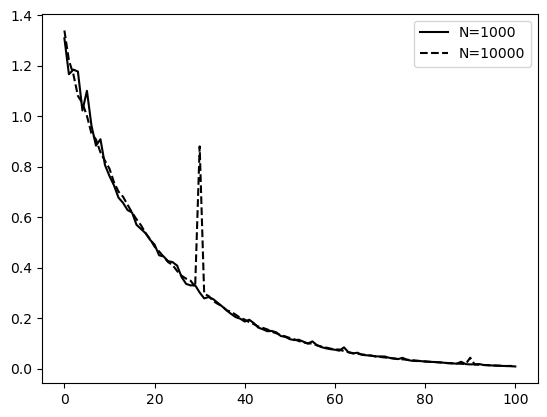

PyObject <matplotlib.legend.Legend object at 0x7fb6f8a45fa0>

In [44]:
Nx=100;
na2=11;
s=1.0;
phit=ones(Nx,);
data1=qmc_init(1000,Nx,na2,s);
data2=qmc_init(10000,Nx,na2,s);
phiout1=qmc_sweep(phit, data1);
phiout2=qmc_sweep(phit, data2);
plot(phiout1.phi_edge,"k-");
plot(phiout2.phi_edge,"k--");
legend(["N=1000", "N=10000"])

Now look at the average values. They do get smoother as N increases.

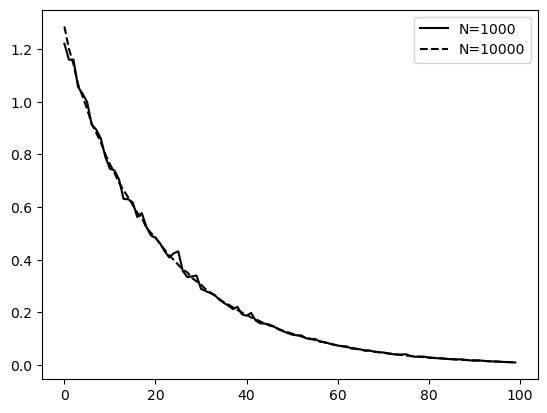

PyObject <matplotlib.legend.Legend object at 0x7fb6d83f4790>

In [45]:
plot(phiout1.phi_avg,"k-");
plot(phiout2.phi_avg,"k--");
legend(["N=1000", "N=10000"])

Now here's trouble. The average flux has a unusually large jump at the left boundary. This 
spells trouble for $d \phi/dx$. Even the small fluctuations elsehwere lead to big problems with dphi. So $d \phi/dx$ is nuts and I may have to do the smoothing unless you can get me a $d \phi/dx$ directly from QMC (ie with no difference approximation).

Start by setting up the plain vanill sn_data to have the same number of cells (Nx) as qmc.

In [46]:
nx=Nx+1;
na2=20;
s=1.0;
sn_data=sn_init(nx, na2, s);
dx=sn_data.dx;

Now try to average the qmc cell average fluxes and get dphi and phi_edge from that.

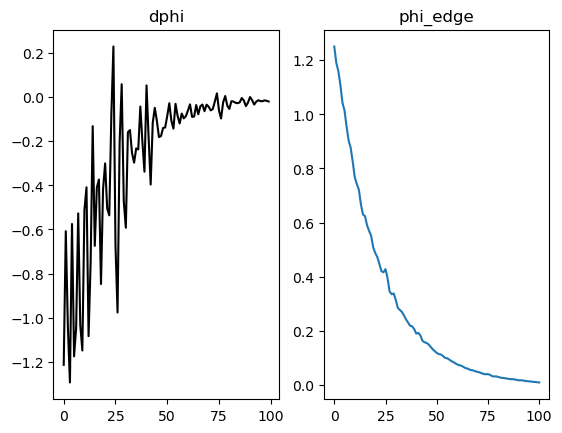

PyObject Text(0.5, 1.0, 'phi_edge')

In [47]:
phi_avg=phiout1.phi_avg;
phi_edge=zeros(Nx+1,);
dphi=zeros(Nx,);
avg2edge!(phi_edge, dphi, phi_avg, dx)
subplot(1,2,1)
plot(dphi,"k-")
title("dphi")
subplot(1,2,2)
plot(phi_edge)
title("phi_edge")

The boundary values on the left are jumping around and a bit inconsisten on the right. The left boundary is really bizzare.

In [48]:
x1=phiout1.phi_avg[95:100];
x2=phiout1.phi_avg[1:6];
[x1 x2]

6×2 Matrix{Float64}:
 1.34766e-02  1.22075e+00
 1.28358e-02  1.16004e+00
 1.17485e-02  1.15996e+00
 1.10119e-02  1.05611e+00
 1.03483e-02  1.03052e+00
 9.38165e-03  9.98601e-01

If I take dphi/dx directly from the QMC code I get in real trouble.

In [51]:
#plain vanilla SN with simple source iteration
snout=sn_solve();
#QMC with simple source iteration, works fine
qout=qmc_nda(1000, 100, 1.e-7;tabulate=true, nda=false)
#QMC with NDA
pout=qmc_nda(1000,100, 1.e-7; tabulate=true);



QMC Exit Distributions
 mu         I(0,-mu)        I(tau,mu) 
 0.05     5.68070e-01     5.85685e-06 
 0.10     5.20190e-01     6.66967e-06 
 0.20     4.40516e-01     9.25581e-06 
 0.30     3.80344e-01     1.54476e-05 
 0.40     3.34182e-01     4.09894e-05 
 0.50     2.97850e-01     1.57446e-04 
 0.60     2.68575e-01     5.36171e-04 
 0.70     2.44506e-01     1.42482e-03 
 0.80     2.24380e-01     3.07485e-03 
 0.90     2.07305e-01     5.68065e-03 
 1.00     1.92639e-01     9.35441e-03 
QMC-NDA Exit Distributions
 mu         I(0,-mu)        I(tau,mu) 
 0.05     6.35737e+09     7.18666e+04 
 0.10     1.60411e+10     7.18758e+04 
 0.20     4.40904e+10     7.18599e+04 
 0.30     5.50890e+10     1.07860e+05 
 0.40     5.68967e+10     1.39910e+06 
 0.50     5.52362e+10     1.10060e+07 
 0.60     5.23998e+10     4.31392e+07 
 0.70     4.92842e+10     1.11962e+08 
 0.80     4.62405e+10     2.24922e+08 
 0.90     4.33989e+10     3.81616e+08 
 1.00     4.07972e+10     5.76051e+08 


Here's a plot of the converged fluxes. QMC and SN agree without NDA and QMC-NDA is wrong.

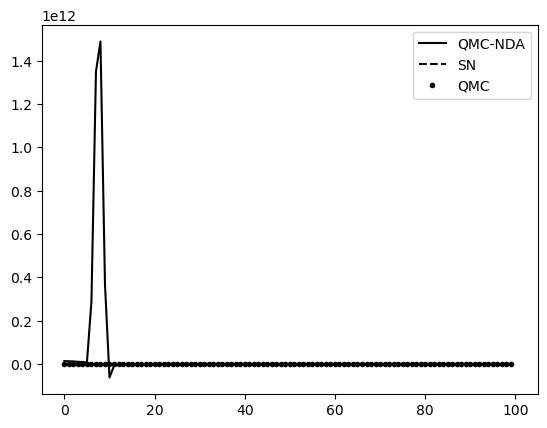

PyObject <matplotlib.legend.Legend object at 0x7fb6e8a52460>

In [50]:
plot(pout.phiout,"k-")
plot(snout,"k--")
plot(qout.phiout,"k.")
legend(["QMC-NDA","SN","QMC"])